<a href="https://colab.research.google.com/github/Gabriel-git24/Cacao_disease_classification/blob/main/Capstone_project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.utils import class_weight
import numpy as np
import pathlib

data_dir = "/content/drive/MyDrive/Capstone Project/archive (5)/split_dataset"
image_size = (224, 224)
batch_size = 32
num_epochs = 50

class_names = [
    "Cassava___bacterial_blight",
    "Cassava___brown_streak_disease",
    "Cassava___green_mottle",
    "Cassava___mosaic_disease",
    "Cassava___healthy"
]

num_classes = len(class_names)

mixed_precision.set_global_policy('mixed_float16')

train_generator = tf.keras.utils.image_dataset_from_directory(
    f"{data_dir}/train",
    image_size=image_size,
    batch_size=batch_size,
    label_mode="categorical",
    shuffle=True
)

val_generator = tf.keras.utils.image_dataset_from_directory(
    f"{data_dir}/val",
    image_size=image_size,
    batch_size=batch_size,
    label_mode="categorical",
    shuffle=False
)

test_generator = tf.keras.utils.image_dataset_from_directory(
    f"{data_dir}/test",
    image_size=image_size,
    batch_size=batch_size,
    label_mode="categorical",
    shuffle=False
)

AUTOTUNE = tf.data.AUTOTUNE
train_generator = train_generator.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
val_generator = val_generator.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
test_generator = test_generator.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)

Found 14975 files belonging to 5 classes.
Found 3207 files belonging to 5 classes.
Found 3215 files belonging to 5 classes.


In [16]:
def build_resnet_classifier_v1(input_shape=(224, 224, 3), num_classes=5, learning_rate=1e-5):

  data_augmentation = tf.keras.Sequential([
      layers.RandomFlip("horizontal_and_vertical"),
      # layers.RandomRotation(0.1),
      # layers.RandomZoom(0.1),
      # layers.RandomContrast(0.1)
  ], name="augmentation_layer")

  base_model = ResNet50(
      weights = "imagenet",
      include_top = False,
      input_shape = input_shape
  )

  #freezing the base layers initially
  base_model.trainable = False

  #defining architecture
  model = models.Sequential([
      #define the input shape
      layers.Input(shape=input_shape),

      #inserting data augmentation
      data_augmentation,

      base_model,
      layers.GlobalAveragePooling2D(),
      layers.Dense(256, activation="relu"),
      layers.Dropout(0.5),
      layers.Dense(num_classes, activation="softmax", dtype="float32")
  ])

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      loss="categorical_crossentropy",
      metrics=['accuracy']
  )

  return model


In [17]:
model = build_resnet_classifier_v1(input_shape=(224, 224, 3), num_classes=5)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augmentation_layer (Sequential) │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,541 (91.99 MB)

 Trainable params: 525,829 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [18]:
data_dir_train = f"{data_dir}/train"

# Get class names in alphabetical order (same as Keras)
class_names_sorted = sorted([d.name for d in pathlib.Path(data_dir_train).iterdir() if d.is_dir()])

# Count files per class
y_train = []
for idx, class_name in enumerate(class_names_sorted):
    class_path = pathlib.Path(data_dir_train) / class_name
    num_images = len(list(class_path.glob("*")))
    y_train.extend([idx] * num_images)

y_train = np.array(y_train)

weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(enumerate(weights))
print("Computed Class Weights:", class_weight_dict)

Computed Class Weights: {0: np.float64(3.9407894736842106), 1: np.float64(1.9549608355091384), 2: np.float64(1.7934131736526946), 3: np.float64(1.661120354963949), 4: np.float64(0.3251900108577633)}


In [19]:
checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/Capstone Project/models/resnet_v1.keras",
    save_best_only=True,
    monitor="val_accuracy",
)

early_stopping = EarlyStopping(
   monitor='val_loss',
   patience=10,
   restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5
)

# Start training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=num_epochs,
    class_weight=class_weight_dict,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 63s 102ms/step - accuracy: 0.2386 - loss: 2.1879 - val_accuracy: 0.4412 - val_loss: 1.3560 - learning_rate: 1.0000e-05
Epoch 2/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 30s 63ms/step - accuracy: 0.3468 - loss: 1.6657 - val_accuracy: 0.5310 - val_loss: 1.2154 - learning_rate: 1.0000e-05
Epoch 3/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 30s 64ms/step - accuracy: 0.4319 - loss: 1.4446 - val_accuracy: 0.5460 - val_loss: 1.1716 - learning_rate: 1.0000e-05
Epoch 4/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 30s 63ms/step - accuracy: 0.4846 - loss: 1.3549 - val_accuracy: 0.5638 - val_loss: 1.1466 - learning_rate: 1.0000e-05
Epoch 5/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 30s 63ms/step - accuracy: 0.5149 - loss: 1.2954 - val_accuracy: 0.5744 - val_loss: 1.1122 - learning_rate: 1.0000e-05
Epoch 6/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 30s 64ms/step - accuracy: 0.5300 - loss: 1.2766 - val_accuracy: 0.5834 - val_loss: 1.0984 - learning_rate: 1.0000e-05
Epoch 7/50
468/468 ━━━━━━━━━━━━━━━━━━━━ 30s 64ms/st

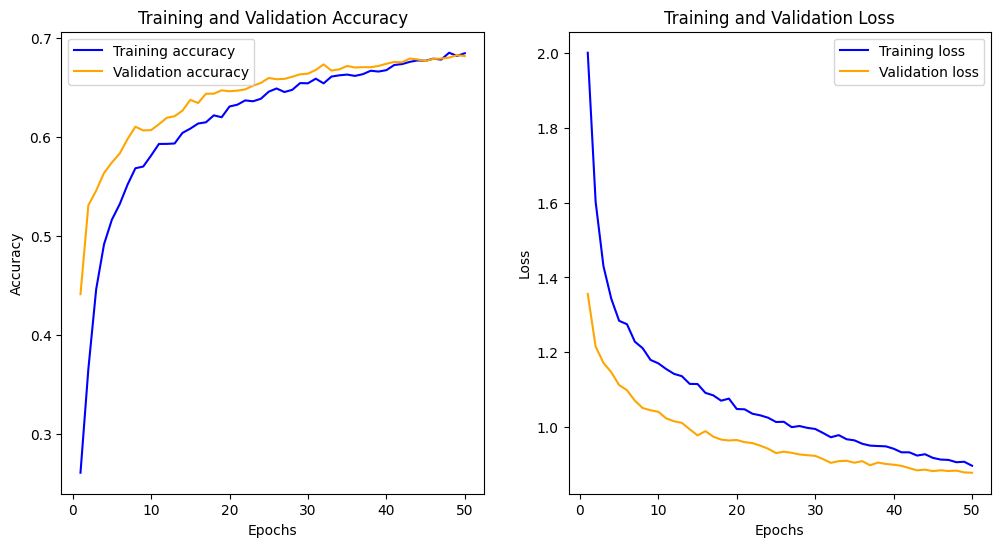

In [20]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# --- PHASE 2: FINE-TUNING ---

for layer in model.layers:
  if "resnet50" in layer.name:
    layer.trainable = True
    print(f"Unfrozen: {layer.name}")

# 2. RE-COMPILE with a VERY SMALL learning rate (1e-6)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

# 3. Train for another 30 epochs
history_fine = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    class_weight=class_weight_dict,
    callbacks=[checkpoint, early_stopping, reduce_lr] # Using your new patience settings
)

Unfrozen: resnet50
Epoch 1/30
468/468 ━━━━━━━━━━━━━━━━━━━━ 147s 188ms/step - accuracy: 0.1381 - loss: 1.7183 - val_accuracy: 0.1244 - val_loss: 3.6599 - learning_rate: 1.0000e-06
Epoch 2/30
468/468 ━━━━━━━━━━━━━━━━━━━━ 70s 149ms/step - accuracy: 0.2055 - loss: 1.5130 - val_accuracy: 0.1512 - val_loss: 2.8936 - learning_rate: 1.0000e-06
Epoch 3/30
468/468 ━━━━━━━━━━━━━━━━━━━━ 70s 148ms/step - accuracy: 0.3042 - loss: 1.4243 - val_accuracy: 0.2130 - val_loss: 2.3158 - learning_rate: 1.0000e-06
Epoch 4/30
468/468 ━━━━━━━━━━━━━━━━━━━━ 70s 149ms/step - accuracy: 0.3915 - loss: 1.3445 - val_accuracy: 0.2691 - val_loss: 2.0097 - learning_rate: 1.0000e-06
Epoch 5/30
468/468 ━━━━━━━━━━━━━━━━━━━━ 70s 148ms/step - accuracy: 0.4587 - loss: 1.3104 - val_accuracy: 0.3162 - val_loss: 1.8234 - learning_rate: 1.0000e-06
Epoch 6/30
468/468 ━━━━━━━━━━━━━━━━━━━━ 70s 148ms/step - accuracy: 0.4886 - loss: 1.2838 - val_accuracy: 0.3383 - val_loss: 1.7607 - learning_rate: 1.0000e-06
Epoch 7/30
468/468 ━━━━━━━

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 1. Extract true labels
y_true = np.concatenate([y for x, y in test_generator], axis=0)

# FIX: Correct check for one-hot encoding (check number of dimensions)
if y_true.ndim > 1:
    y_true = np.argmax(y_true, axis=1)

# 2. Predict
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

# 2. Identify which classes are actually present in your test data
# (This finds which of the 0-4 indices actually exist in y_true)
present_indices = np.unique(y_true).astype(int)
actual_labels = [class_names[i] for i in present_indices]

# 3. Generate Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# 4. Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=actual_labels,
            yticklabels=actual_labels)



plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix: Cassava Disease Classification')
plt.show()

# 5. Classification Report
# We use actual_labels to ensure the count matches the 4 classes found
print(classification_report(y_true, y_pred, target_names=actual_labels))

KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Prepare cleaner labels (remove underscores and capitalize)
clean_labels = [label.replace('__', ' ').replace('_', ' ').title() for label in actual_labels]

# 2. Calculate normalized matrix for percentages
cm = confusion_matrix(y_true, y_pred)
cm_perc = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 3. Create the plot
plt.figure(figsize=(12, 10))
sns.set_context("paper", font_scale=1.2) # Professional font scaling

# Use a mask or distinct colors to make the diagonal (correct hits) stand out
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True,
            xticklabels=clean_labels,
            yticklabels=clean_labels,
            square=True,
            linewidths=.5,
            annot_kws={"size": 12})

# Add formatting details
plt.xlabel('Predicted Label', fontweight='bold', labelpad=15)
plt.ylabel('True Label', fontweight='bold', labelpad=15)
plt.title('Confusion Matrix: Cassava Disease Classification', fontsize=16, pad=20, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Regenerate the classification report, but this time as a dictionary
report = classification_report(y_true, y_pred, target_names=actual_labels, output_dict=True)

# Extract and print the requested metrics
print("Overall Accuracy:", report['accuracy'])
print("\nWeighted Average Precision:", report['weighted avg']['precision'])
print("Weighted Average Sensitivity (Recall):", report['weighted avg']['recall'])

In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

# Assuming y_true, y_pred, and actual_labels are already defined from previous cells
# If not, you might need to re-run the prediction and label extraction steps.

# Generate the classification report as a dictionary
report_dict = classification_report(y_true, y_pred, target_names=actual_labels, output_dict=True)

# Convert the dictionary to a pandas DataFrame for a nice table format
df_report = pd.DataFrame(report_dict).transpose()

# Print the table, excluding the 'support' row for weighted avg and macro avg if desired for clarity
# Also, format numerical columns for better readability
print("\nClassification Report Table:")
print(df_report.round(4))
